# Homework Assignment 2 by Hawk Wang
15-463/663/862, Computational Photography, Fall 2017<br>Carnegie Mellon University

The purpose of this assignment is to explore Eulerian video magnification [1] as a tool for revealing temporal image variations that are difficult to visualize, or even see at all. 

I will show two kind of magnificaition examples, one for color and one for motion. Below is the color magnification frames example:

![colorManipulation](demoImgs2.png)

According to Eulerian video magnification[1] and the assign2 description, there are generally 5 steps to make the effect(below figure is borrowed from [1]):

- **Loading video as frames**
- **Build Laplacian Pyramid for frames**
- **Temporal filtering the frames**
- **Amplify the filtered signal**
- **Recreate video from the amplified signal**

![General Pipleline](keyPipeline.jpg)

I will show these steps one by one and wrap them up as a whole applicaiton.

**Reference:**
```
[1] H.-Y. Wu, M. Rubinstein, E. Shih, J. Guttag, F. Durand, and W. T. Freeman. Eulerian video magnification for revealing subtle changes in the world. ACM Trans. Graph. (Proceedings SIGGRAPH 2012), 31(4), 2012.
```

### 0. Import necessary libraries

Let's import these packages for later use, note I will use numpy to do matrix operation, scipy to do signal processing, matplotlib for data visualization, and cv2 for general image operation.

In [89]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy as sp
import sys
import os
import skimage.color as color
from skimage.transform import pyramid_laplacian
import scipy.fftpack as fftpack
import scipy.signal as signal
%matplotlib inline

### 1. Exploratory analysis

### 1.1 Loading the video
Let load the face.mp4 video and do some basic analysis. If I load the fullfile it will occupy more than 2GB memory. When we do further processing such as pyramid generation it needs more memory. If we are working on a long time video we have to use harddisk instead of ram to store the middle result. But because face.mp4 is only 301 frames video we can use ram directly. Here in this notebook cell lets only load 60 frames for simplification, it occupies 450MB.

In [90]:
def getVideoFrames(videoFilePath, startFrameNumber=-1, endFrameNumber=-1):
    """
    Loading video file between startFrameNumber and endFrameNumber.
    Each frame is converted to YIQ color space before saving to output matrix.
    
    Parameters
    ----------
    vidoFilePath: video file path
    startFrameNumber: start frame number to read. If it is -1, then start from 0
    endFrameNumber: end frame number to read. If it is -1, then set it to the total frame number

    Returns
    -------
    fps: frame rate of the video
    frames: frames matrix with the shape (frameCount, frameHeight, frameWidth, channelCount)
    """
    frames=[]
    vidcap = cv2.VideoCapture(videoFilePath)
    fps=vidcap.get(cv2.CAP_PROP_FPS)
    totalFrame=vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
    if startFrameNumber==-1:
        startFrameNumber = 0
    if endFrameNumber == -1:
        endFrameNumber = totalFrame - 1
    success,image = vidcap.read()
    count = 0
    success = True
    while success:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = color.rgb2yiq(image).astype(np.float32)
    
      if count<startFrameNumber:
        success,image = vidcap.read()
        count+=1
        continue
      elif count>=endFrameNumber:
        break
      else:        
          frames.append(image)
      success,image = vidcap.read()
      count += 1
    frames=np.array(frames)
    
    return fps, frames

In [91]:
DEBUG=1
if DEBUG==1:
    fps, frames = getVideoFrames('./data/face.mp4', -1, -1)
    print("The video framerate is %.0f fps"%fps)
    print("Success read %d frames."%frames.shape[0], "We save them in a numpy array with shape:", frames.shape, ", which occupies %d bytes"%sys.getsizeof(frames))    


The video framerate is 30 fps
Success read 300 frames. We save them in a numpy array with shape: (300, 592, 528, 3) , which occupies 1125273744 bytes


In [92]:
frames.dtype

dtype('float32')

### 1.2 Show the frames
Lets show two frames of the video. I define a tool function **compareImg** for convinient use.

In [93]:
def compareImg(leftImg, rightImg, roi, leftTitle, rightTitle):
    """
    Compare input image pair, showing full images and the ROIs
    
    Parameters
    ----------
    leftImg, rightImg: left image and right image to compare
    roi: list of [top, bottom, left, right, extend] of ROI
    leftTitle, rightTitle: figure titles

    Returns
    -------
    Filtered image, same type as input image
    """
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.imshow(leftImg)
    plt.title(leftTitle)

    plt.subplot(2,2,2)
    plt.imshow(rightImg)
    plt.title(rightTitle)
    
    ax = plt.subplot(2, 2, 3)
    top, bottom, left, right, extend = roi
    rect = plt.Rectangle([left, top], right-left, bottom-top, edgecolor='Red', facecolor='None')
    ax.add_patch(rect)    
    plt.imshow(leftImg)
    plt.ylim(bottom+extend, top-extend)
    plt.xlim(left-extend, right+extend)
    plt.title("ROI of " + leftTitle)
    
    ax = plt.subplot(2, 2, 4)
    top, bottom, left, right, extend = roi
    rect = plt.Rectangle([left, top], right-left, bottom-top, edgecolor='Red', facecolor='None')
    ax.add_patch(rect)    
    plt.imshow(rightImg)
    plt.ylim(bottom+extend, top-extend)
    plt.xlim(left-extend, right+extend)
    plt.title("ROI of " + rightTitle)

    plt.show()

def castFloatArray(imgIn, lowLimit=-1, highLimit=1):
    """
    Cast input float array value to between [lowLimit, highLimit]
    
    Parameters
    ----------
    imgIn: input image array

    Returns
    -------
    output image, value between [lowLimit, highLimit]
    """
    imgOut=imgIn.copy()
    if imgIn.dtype==np.float32 or imgIn.dtype==np.float64:
        imgOut[imgOut>highLimit] = highLimit
        imgOut[imgOut<lowLimit] = lowLimit
    return imgOut

def normFloatArray(imgIn):
    """
    Normalize input float array value to between [0, 1]
    If the input image has multi-channels, it does the normalization
    channel by channel, independently.
    
    Parameters
    ----------
    imgIn: input image array

    Returns
    -------
    output image, value between [0, 1]
    """
    imgOut = imgIn.copy()
    if imgIn.max()==imgIn.min():
        imgOut = np.zeros(imgIn.shape)
    elif len(imgIn.shape)==2:        
        imgOut = (imgOut - imgOut.min())/(imgOut.max()-imgOut.min())
    elif len(imgIn.shape)==3:
        for c in range(3):
            imgOut[:,:,c] = (imgOut[:,:,c] - imgOut[:,:,c].min())/(imgOut[:,:,c].max()-imgOut[:,:,c].min())
    return imgOut.astype(np.float32)

def yiq2rgbUint(imgIn):
    imgOut=(255*normFloatArray(color.yiq2rgb(castFloatArray(imgIn)))).astype(np.uint8)
    return imgOut 

def yiq2bgrUint(imgIn):
    imgOut=(255*normFloatArray(color.yiq2rgb(castFloatArray(imgIn)))).astype(np.uint8)
    imgOut=cv2.cvtColor(imgOut, cv2.COLOR_RGB2BGR)
    return imgOut 

def yiq2rgbFloat(imgIn):
    imgOut=normFloatArray(color.yiq2rgb(castFloatArray(imgIn)))
    return imgOut 

def yiq2bgrFloat(imgIn):
    tmp=imgOut=normFloatArray(color.yiq2rgb(castFloatArray(imgIn)))
    imgOut=tmp.copy()
    imgOut[:,:,0] = tmp[:,:,2]
    imgOut[:,:,1] = tmp[:,:,1]
    imgOut[:,:,2] = tmp[:,:,0]
    return imgOut 


def compareFrames(frames, frameId1, frameId2, roi):
    """
    Compare two frames in input video frames.
    The frame is converted to RGB color space before display.
    
    Parameters
    ----------
    imgIn: input image array

    Returns
    -------
    output image, value between [0, 1]
    """
    frame1=frames[frameId1,:,:,:]
    frame2=frames[frameId2,:,:,:]
    frame1rgb=yiq2rgbFloat(frame1)
    frame2rgb=yiq2rgbFloat(frame2)
    compareImg(frame1rgb, frame2rgb, roi, 'Frame %d'%frameId1, 'Frame %d'%frameId2)    

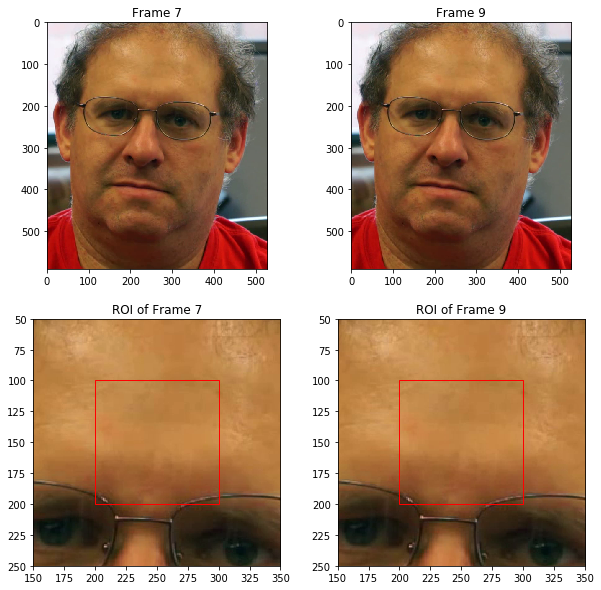

In [94]:
if DEBUG==1:
    roi = [100, 200, 200, 300, 50]
    compareFrames(frames, 7, 9, roi)

### 1.3 Demo the temporal signal 
For face.mp4, there is totally 10 second video which contains 300 frames, so how about the pixel value changes between frames? I choose to observe one pixel at (y=300, x=200), as below. I can't tell the trends in the signal so I process the video frames further, according to the references.

In [95]:
def draw1DTemporalSignal(frames, ypos, xpos, fps):
    frameNum, H, W, chNum = frames.shape
    tlist = [t*1000/fps for t in range(frameNum)]
    plt.figure(figsize=(20,5))
    chName=['y', 'i', 'q']
    for c in range(chNum):
        plt.subplot(1,3,c+1)
        plt.plot(tlist, frames[:,ypos, xpos, c], 'r-')
        plt.title("%s channel pixel value change for point(%d, %d)"%(chName[c], ypos, xpos))
        plt.xlabel('Time(ms)')
        plt.ylabel('Pixel Value')
    plt.show()

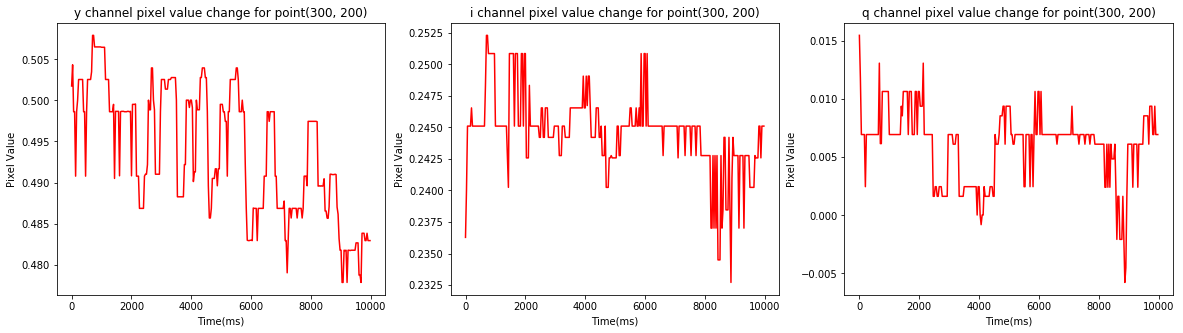

In [96]:
if DEBUG==1:
    draw1DTemporalSignal(frames, 300, 200, fps)

### 2.0 Build and Test Laplacian Pyramid

### 2.1 Laplacian Pyramid for single image

First lets build laplacian pyramid for a single image. I do it just as the course lectures shows

![createLapPyr](createLapPyr.jpeg)
![reconsLapPyr](reconsLapPyr.jpeg)

In [97]:
def buildLaplacianPyramid(imgIn, maxLevel):
    """
    Build up to maxLevel laplacian pyramid for input image
    
    Parameters
    ----------
    imgIn: input image array
    maxLevel: upper limit of the pyramid levels. I also limit
           the smallest image edge in the pyramid should larger than 4 pixels
           
    Note
    ----------
    In the blur steps, it use a Gaussian filter with sigmaX=3, and sigmaY=3
    
    Returns
    -------
    Image pyramid, up to maxLevel
    """    
    currentLayer=0
    imgPyramid = []
    curSrc = imgIn.astype(np.float32)
    while(currentLayer<maxLevel-1):
        curH, curW = curSrc.shape[0:2]
        if curH < 4 or curW < 4:
            break
        currentLayer+=1 
        imgBlur=cv2.GaussianBlur(curSrc, ksize=(0, 0), sigmaX=3)
        imgBlurDown=cv2.resize(imgBlur, ((curW+1)//2, (curH+1)//2))
        imgBlurUp = cv2.resize(imgBlurDown, (curW, curH))
        imgBlurUp = cv2.GaussianBlur(imgBlurUp, ksize=(0, 0), sigmaX=3)
        imgDiff=curSrc-imgBlurUp
        imgPyramid.append(imgDiff)
        curSrc = imgBlurDown

    imgPyramid.append(curSrc)
    return imgPyramid

def recreateImgsFromLapPyr(imgPyramid):
    """
    Recreate image from input Laplacian Pyramid
    
    Parameters
    ----------
    imgPyramid: input Laplacian Pyramid
    
    Note
    ----------
    In the blur step, it use a Gaussian filter with sigmaX=3, and sigmaY=3
    
    Returns
    -------
    Image recreated from inut Laplacian Pyramid
    """    
    layerNum = len(imgPyramid)
    curSrc=imgPyramid[-1].copy()
    for l in np.arange(layerNum-2, -1, -1):
        imgUp = cv2.resize(curSrc, (imgPyramid[l].shape[1], imgPyramid[l].shape[0]))
        imgBlurUp = cv2.GaussianBlur(imgUp, ksize=(0, 0), sigmaX=3)
        curSrc = imgBlurUp + imgPyramid[l]
        
    return(curSrc)    

Lets test above 2 functions, the following figures show that we can reconstruct image from the input Laplacian pyramid that is visually no different with input image, and the pyramid has specified levels with differential image that we need.

```
Note: I use maxLevel=4 for face.mp4
```

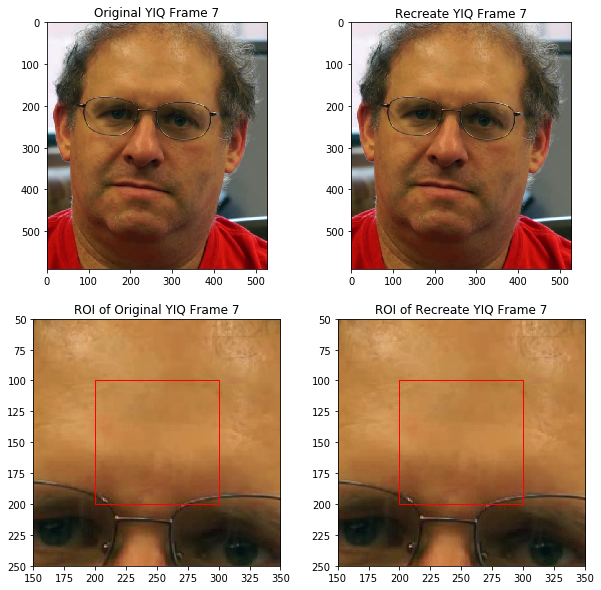

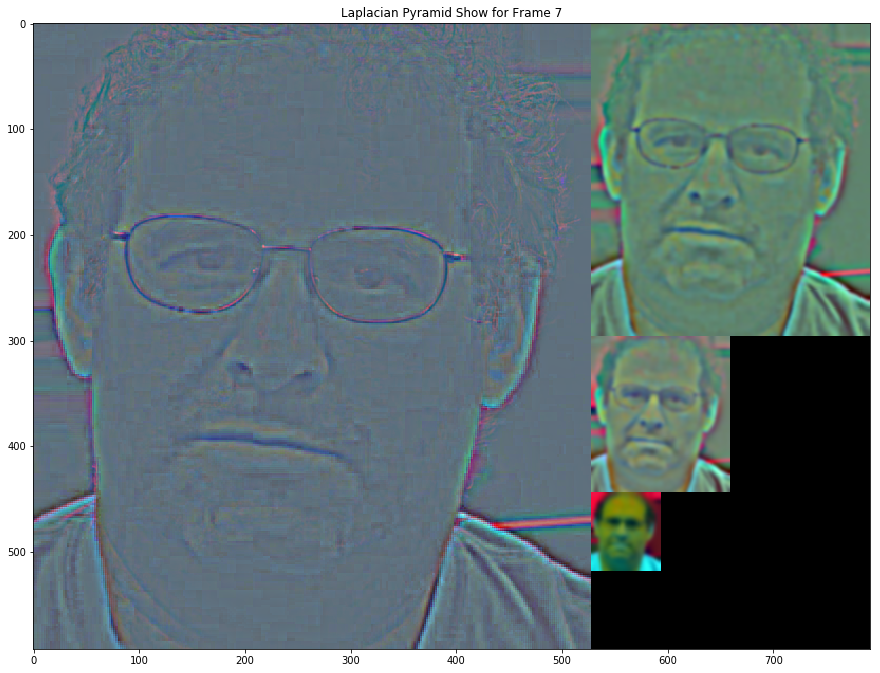

In [98]:
def testImgPyramid(image, maxLevel, roi):
    imgPyramid = buildLaplacianPyramid(image, maxLevel)
    recreateImg = recreateImgsFromLapPyr(imgPyramid)
    recreateImg=yiq2rgbFloat(recreateImg)
    compareImg(yiq2rgbFloat(image), recreateImg, roi, "Original YIQ Frame 7", "Recreate YIQ Frame 7")

def testShowPyramid(image, maxLevel):
    rows, cols = image.shape[0:2]
    imgPyramid = buildLaplacianPyramid(image, maxLevel)
    composite_image = np.zeros((rows, cols + cols // 2, 3), dtype=np.float32)
    composite_image[:rows, :cols, :] = normFloatArray(imgPyramid[0])
    i_row = 0
    for p in imgPyramid[1:]:
        n_rows, n_cols = p.shape[:2]
        composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = normFloatArray(p)
        i_row += n_rows

    plt.figure(figsize=(15,15))
    plt.title("Laplacian Pyramid Show for Frame 7")
    plt.imshow(composite_image)
    plt.show()

if DEBUG==1:    
    testFrame = frames[7]
    maxLevel=4
    roi = [100, 200, 200, 300, 50]
    testImgPyramid(testFrame, maxLevel, roi)
    testShowPyramid(testFrame, maxLevel)

### 2.2 Laplacian Pyramid for video
Function **buildVideoLapPyr** and **recreateVideoFromLapPyr** are used to generate video pyramid, they call **buildLaplacianPyramid** and **recreateImgsFromLapPyr** to do the job.

The following figure shows what this step do:

![Laplacian Pyramid for Video](videoPyramid.jpg)

In [99]:
def buildVideoLapPyr(frames, maxLevel):
    """
    Build Laplacian pyramid for input video frames
    
    Parameters
    ----------
    frames: input video frames
    maxLevel: upper limit of the Laplician pyramid layers
    
    Returns
    -------
    Laplacian pyramid for input video frames, which is a list of 
    videos that each video mapping to a layer in the laplacian pyramid.
    So each video has the shape (frameCount, videoFrameHeight, videoFrameWidth, channelCount).
    """     
    pyr0=buildLaplacianPyramid(frames[0], maxLevel)
    realMaxLevel=len(pyr0)
    
    resultList=[]
    for i in range(realMaxLevel):
        curPyr = np.zeros([len(frames)]+list(pyr0[i].shape), dtype=np.float32)
        resultList.append(curPyr)
        
    for fn in range(len(frames)):
        pyrOfFrame = buildLaplacianPyramid(frames[fn], maxLevel)
        for i in range(realMaxLevel):
            resultList[i][fn]=pyrOfFrame[i]
            
    return resultList

def recreateVideoFromLapPyr(pyrVideo):
    """
    Recreate video from input video Laplacian Pyramid
    
    Parameters
    ----------
    pyrVideo: input Laplacian Pyramid for video, returned by buildVideoLapPyr
     
    Returns
    -------
    Video recreated from inut Laplacian Pyramid
    """        
    maxLevel=len(pyrVideo)
    fNumber, H, W, chNum=pyrVideo[0].shape
    videoResult=np.zeros(pyrVideo[0].shape, dtype=np.float32)
    for fn in range(videoResult.shape[0]):
        framePyr=[pyrVideo[i][fn] for i in range(maxLevel)]
        videoResult[fn]=recreateImgsFromLapPyr(framePyr)
        
    return videoResult

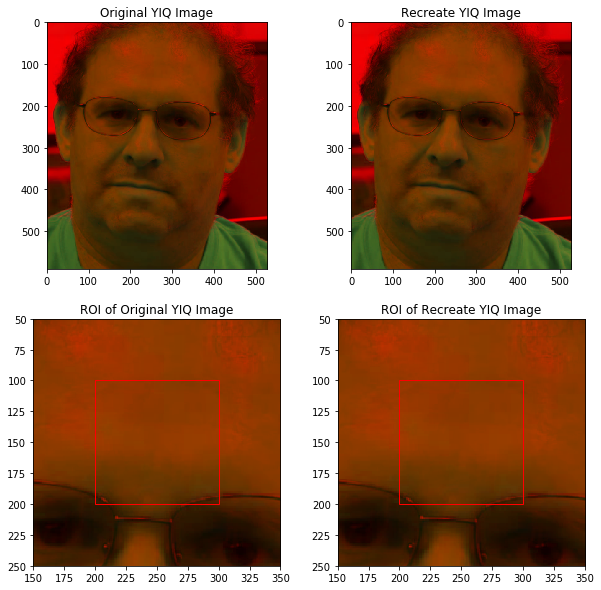

In [100]:
if DEBUG==1:
    frameNumber=300
    pyrVideo=buildVideoLapPyr(frames[0:frameNumber], maxLevel)
    recreateFrames=recreateVideoFromLapPyr(pyrVideo)

    compareImg(castFloatArray(frames[5], 0, 1), castFloatArray(recreateFrames[5], 0, 1), roi, "Original YIQ Image", "Recreate YIQ Image")

### 3. Temporal Filtering

![Temporal Filter](temporalFilter2.jpg)

### 3.1 Showing Temporal Signal
Now let's do temporal filter to the video laplacian pyramid. But first lets check the temporal signal for one single pixel (y=180, x=240) on the pyramid， here I only show 2 layers of the pyramid

In [101]:
def showTemporalSignal(frames, fps, pyrVideo, layer, ypos, xpos, keyword=""):
    """
    Show temporal signal for specified layers of input video Laplacian Pyramid,
    on specified position.
    
    Parameters
    ----------
    frames: original frames
    pyrVideo: input Laplacian Pyramid for original frames, returned by buildVideoLapPyr
    layer: specified layer number to watch
    ypos, xpos: specified position to watch
     
    Returns
    -------
    None
    """      
    tlist = [t*1000/fps for t in range(pyrVideo[layer].shape[0])]
    plt.figure(figsize=(30,5))
    chName=['Y', 'I', 'Q']
    chNum = len(chName)
    ax=plt.subplot(1,4,1)
    plt.title("Frame 0 Layer %d of the %s Pyramid"%(layer, keyword))
    frame2show=normFloatArray(pyrVideo[layer][0])
    markRadius=10
    rect = plt.Rectangle([(xpos-markRadius)>>layer, (ypos-markRadius)>>layer], markRadius*2>>layer, markRadius*2>>layer, edgecolor='Red', facecolor='red')
    plt.imshow(frame2show)
    ax.add_patch(rect)
    for c in range(chNum):
        plt.subplot(1,4,c+2)
        plt.plot(tlist, pyrVideo[layer][:,ypos>>layer,xpos>>layer,c],'r-')
        plt.title("Layer %d:%s channel value for point(%d, %d)"%(layer, chName[c], ypos, xpos))
        plt.xlabel('Time(ms)')
        plt.ylabel('Pixel Value')
    plt.show()

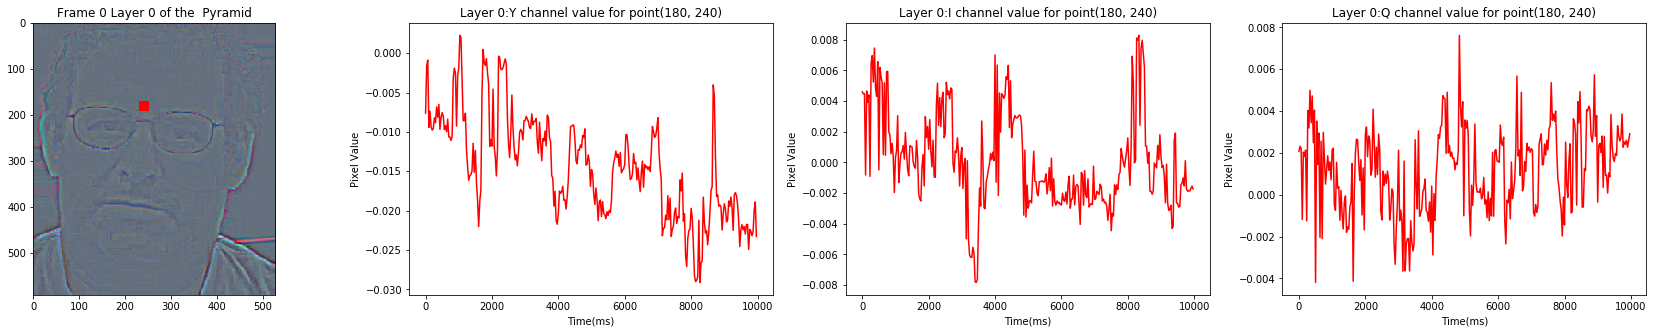

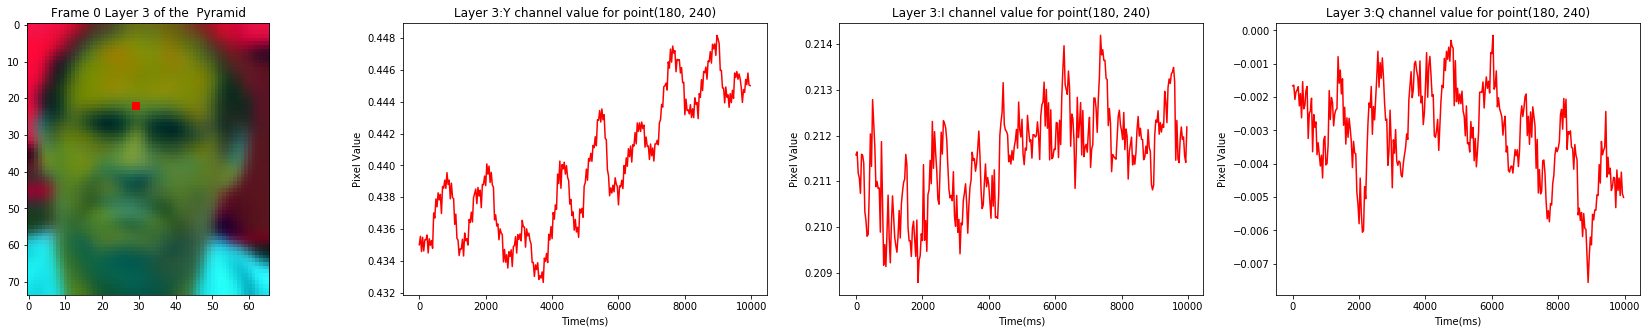

In [102]:
if DEBUG==1:
    ypos=180
    xpos=240
    showTemporalSignal(frames, fps, pyrVideo, 0, ypos, xpos)
    showTemporalSignal(frames, fps, pyrVideo, maxLevel-1, ypos, xpos)

### 3.2 Chose and Implement Temporal Band Filter
How to filter such signal showing in above figure? According to the original paper:

```
The Choice of filter is generally application dependent. For motion magnification, a filter with a broad passband is prefered; for color amplification of blood flow, a narrow passband produce a more noise-free result.
```

Below figure shows the filters used by the original paper:

![Band Filters](bandFilters.jpg)

So I choose to use ideal low pass filter to do the temporal filtering, the following **temporal_ideal_filter** function is borrowed from https://github.com/flyingzhao/PyEVM. I choose the band filter between 0.83Hz and 1.1Hz, and I compare the original signal and the filtered signal for different layers, and you can see the apparent pattern in my filtered signal.

In [103]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5, axis=0):
    """
    Apply butterworth bandpass filter on input data on specified axis.
    
    Parameters
    ----------
    data : data to be filered
    lowcut, hightcut: the cut frequency of the bandpass filter
    fs   : sample rate
    order: The order of the filter
    axis : The axis of the input data array along which to apply the linear filter. 
          The filter is applied to each subarray along this axis.
     
    Returns
    -------
    None
    """       
    omega = 0.5 * fs
    low = lowcut / omega
    high = highcut / omega
    b, a = signal.butter(order, [low, high], btype='band')
    y = signal.lfilter(b, a, data, axis=0)
    return y

def temporal_ideal_filter(tensor,low,high,fps,axis=0):
    """
    Apply Ideal bandpass filter on input data on specified axis.
    
    Parameters
    ----------
    tensor : data to be filered
    low, hight: the cut frequency of the bandpass filter
    fps   : sample rate
    axis : The axis of the input data array along which to apply the linear filter. 
          The filter is applied to each subarray along this axis.
     
    Returns
    -------
    None
    """      
    fft=fftpack.fft(tensor,axis=axis)
    frequencies = fftpack.fftfreq(tensor.shape[0], d=1.0 / fps)
    bound_low = (np.abs(frequencies - low)).argmin()
    bound_high = (np.abs(frequencies - high)).argmin()
    if (bound_low==bound_high) and (bound_high<len(fft)-1):
        bound_high+=1
    fft[:bound_low] = 0
    fft[bound_high:-bound_high] = 0
    fft[-bound_low:] = 0
    iff=fftpack.ifft(fft, axis=axis)
    
    return np.abs(iff)

def idealFilterForVideoPyr(videoPyr, low, high, fps, roi=None):
    """
    Apply Ideal bandpass filter on input video pyramid
    
    Parameters
    ----------
    videoPyr : video pyramid
    low, hight: the cut frequency of the bandpass filter
    fps   : sample rate
    roi : if specified, only filter roi of frames. [TODO]Not implemented yet.
     
    Returns
    -------
    None
    """     
    resultVideoPyr=[]
    for layer in range(len(videoPyr)):
        filteredPyr = temporal_ideal_filter(videoPyr[layer], low, high, fps, axis=0)
        resultVideoPyr.append(filteredPyr)
        
    return resultVideoPyr

def buttFilterForVideoPyr(videoPyr, low, high, fps, roi=None):
    """
    Apply Buttworth bandpass filter on input video pyramid
    
    Parameters
    ----------
    videoPyr : video pyramid
    low, hight: the cut frequency of the bandpass filter
    fps   : sample rate
    roi : if specified, only filter roi of frames. [TODO]Not implemented yet.
     
    Returns
    -------
    None
    """      
    resultVideoPyr=[]
    for layer in range(len(videoPyr)):
        filteredPyr = butter_bandpass_filter(videoPyr[layer], low, high, fps, order=1, axis=0)
        resultVideoPyr.append(filteredPyr)
        
    return resultVideoPyr

In [114]:
#Test ideal IIR filter
if DEBUG==1:
    freqLow = 0.83/2
    freqHigh = 1.0/2
    filteredVideoPyr=idealFilterForVideoPyr(pyrVideo, freqLow, freqHigh, fps)
    filteredVideo   =recreateVideoFromLapPyr(filteredVideoPyr)

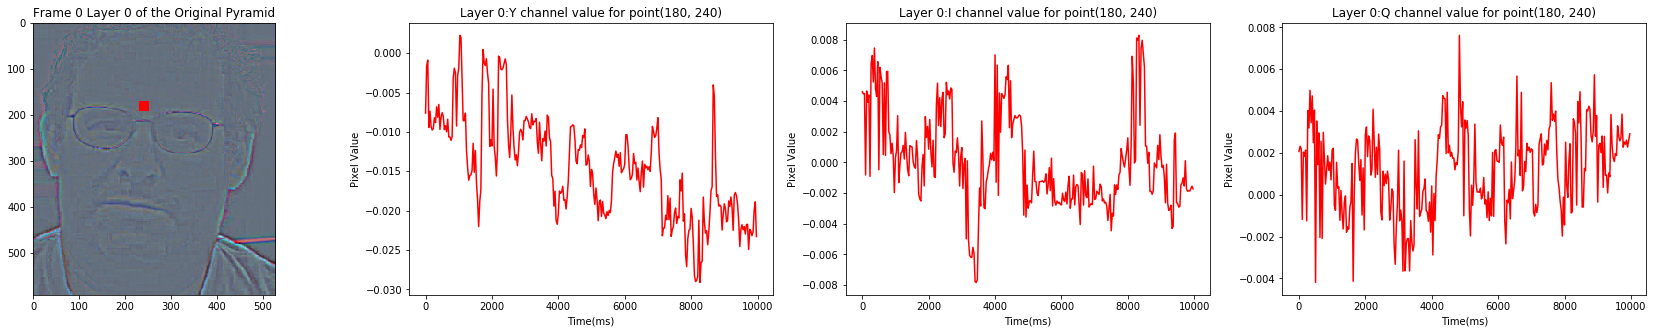

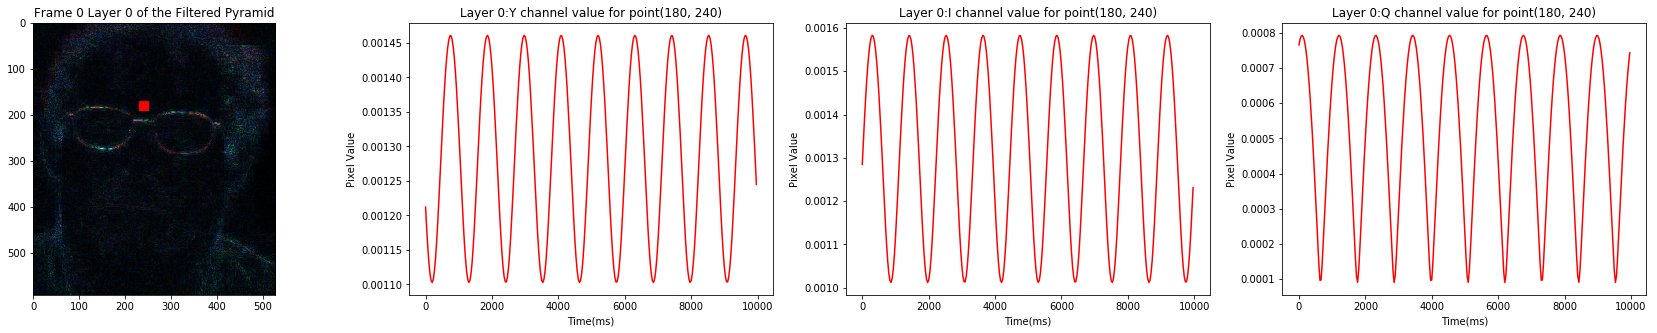

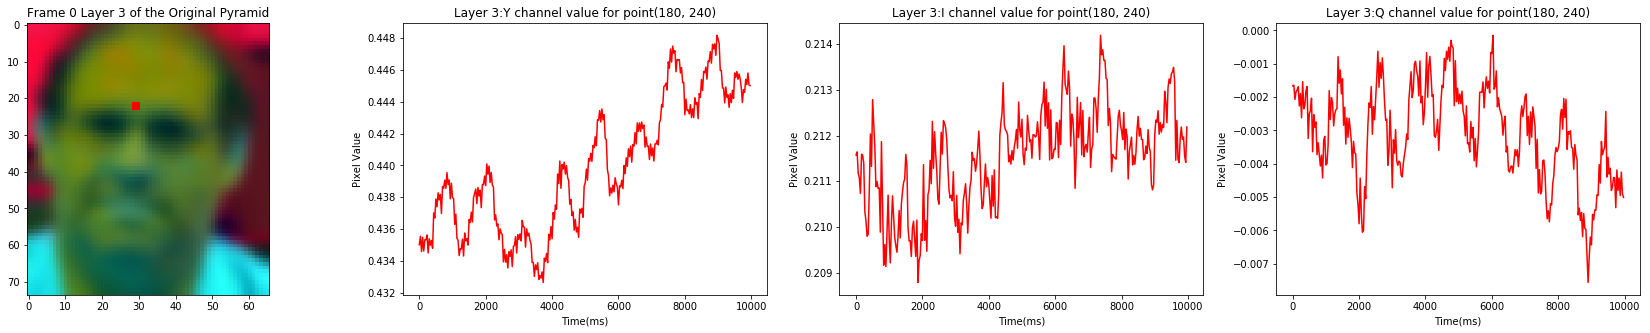

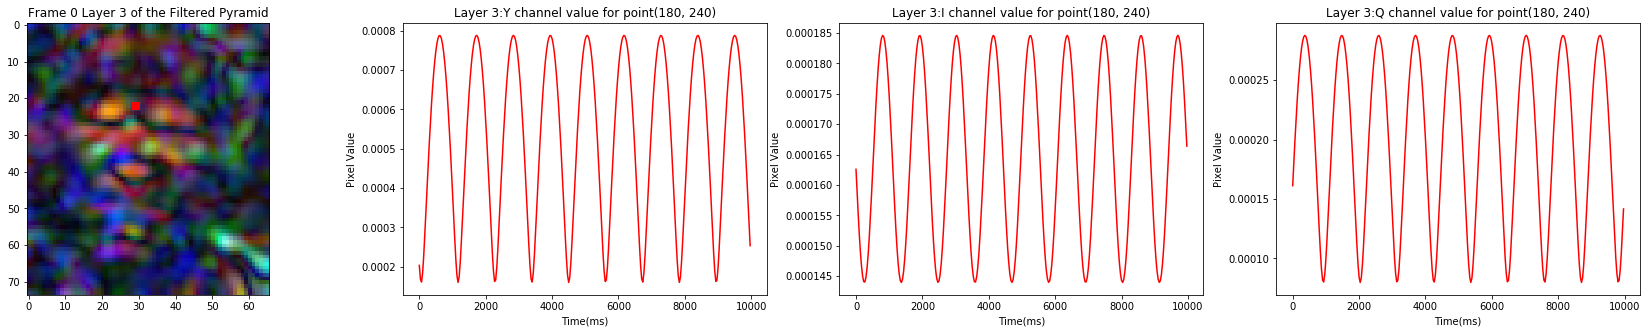

In [115]:
if DEBUG==1:
    ypos=180
    xpos=240
    showTemporalSignal(frames, fps, pyrVideo, 0, ypos, xpos, "Original")
    showTemporalSignal(frames, fps, filteredVideoPyr, 0, ypos, xpos, "Filtered")
    showTemporalSignal(frames, fps, pyrVideo, maxLevel-1, ypos, xpos, "Original")
    showTemporalSignal(frames, fps, filteredVideoPyr, maxLevel-1, ypos, xpos, "Filtered")

The above figures clearly show that we get a single frequency signal of input array, which is sin/cos like perodic signal.

### 3.3 Amplify the filtered temporal signal

![Amplify Signal](amplifySignal.jpg)
According to the paper there are many choises for signal amplification. For example, I can choose different amplification ratio for different spatial layers and for different color channels. Here for simplification I implement a very simple function **amplifyTemporalSignal**, which only amplify the top layer of the pyramid.

In [116]:
def amplifyTemporalColorSignal(originalPyr, filteredVideoPyr, alpha, chromAttenuation):
    """
    Amplify the input temporal color change signal
    
    Parameters
    ----------
    originalPyr : original video Laplacian pyramid
    filteredVideoPyr: temporal filtered video laplacian pyramid
    alpha   : amplify ratio
    chromAttenuation : for I/Q channel we can use this value for some attenuation, according to [1] 
     
    Returns
    -------
    Amplified color change signal
    """       
    amplifiedPyr=[]
    
    for layer in range(len(filteredVideoPyr)):
        tensor = originalPyr[layer].copy()
        if layer==len(filteredVideoPyr)-1:
            tensor[:,:,:,0] += filteredVideoPyr[layer][:,:,:,0] * alpha
            tensor[:,:,:,1] += filteredVideoPyr[layer][:,:,:,1] * alpha * chromAttenuation
            tensor[:,:,:,2] += filteredVideoPyr[layer][:,:,:,2] * alpha * chromAttenuation
            
        amplifiedPyr.append(tensor)
        
    return amplifiedPyr 

def amplifyTemporalMotionSignal(originalPyr, filteredVideoPyr, alpha, lambdaC, chromAttenuation):
    """
    Amplify the input temporal motion signal
    
    Parameters
    ----------
    originalPyr : original video Laplacian pyramid
    filteredVideoPyr: temporal filtered video laplacian pyramid
    alpha   : amplify ratio
    chromAttenuation : for I/Q channel we can use this value for some attenuation, according to [1] 
     
    Returns
    -------
    Amplified motion signal
    """       
    amplifiedPyr=[]
    
    delta = lambdaC/8/(1+alpha)
    frameCount, H, W, chCount= originalPyr[0].shape
    lamb = np.sqrt(H**2+W**2)/3.0

    for layer in range(len(filteredVideoPyr)):
        tensor = originalPyr[layer].copy()
        if layer==len(filteredVideoPyr)-1 or layer==0:
            currAlpha = 0
        elif currAlpha > alpha:
            currAlpha = alpha
        else:
            currAlpha = lamb/delta/8 - 1
            
        tensor[:,:,:,0] += filteredVideoPyr[layer][:,:,:,0] * currAlpha
        tensor[:,:,:,1] += filteredVideoPyr[layer][:,:,:,1] * currAlpha * chromAttenuation
        tensor[:,:,:,2] += filteredVideoPyr[layer][:,:,:,2] * currAlpha * chromAttenuation
            
        amplifiedPyr.append(tensor)
        lamb /= 2
        
    return amplifiedPyr 

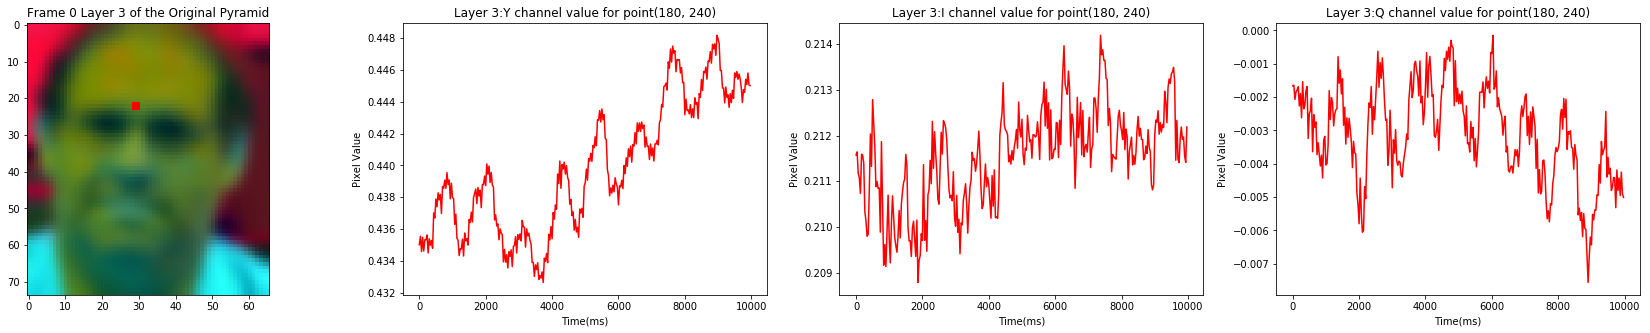

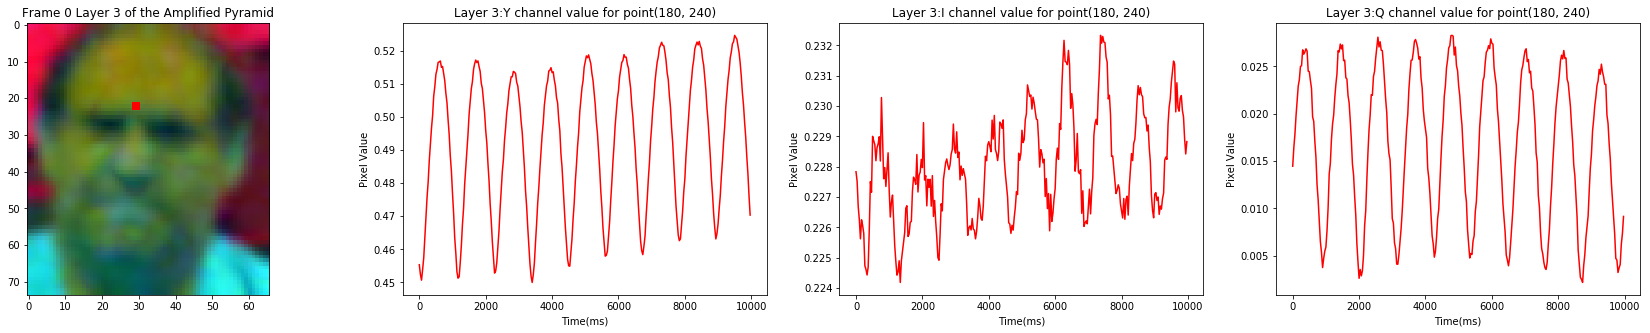

In [117]:
if DEBUG==1:
    alpha = 100 #The original paper's parameter value 
    amplifiedPyr = amplifyTemporalColorSignal(pyrVideo, filteredVideoPyr, alpha, 1)
    showTemporalSignal(frames, fps, pyrVideo, maxLevel-1, ypos, xpos, "Original")
    showTemporalSignal(frames, fps, amplifiedPyr, maxLevel-1, ypos, xpos, "Amplified")

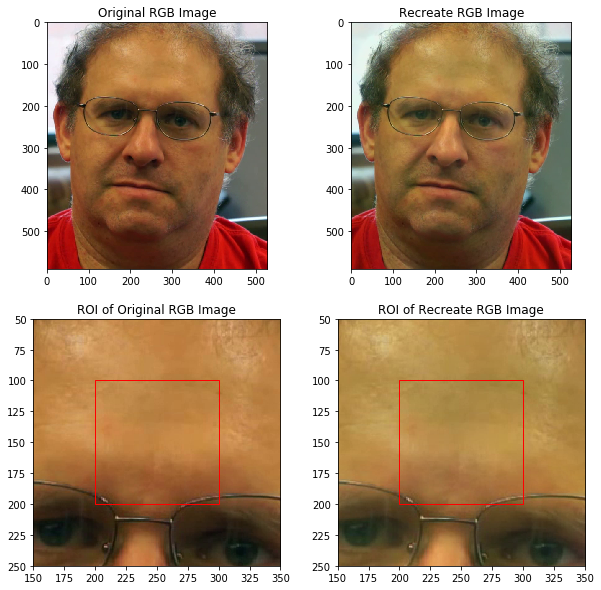

In [118]:
if DEBUG==1:
    recreateFrames=recreateVideoFromLapPyr(amplifiedPyr)
    compareImg(yiq2rgbFloat(frames[20]), yiq2rgbFloat(recreateFrames[20]), roi, "Original RGB Image", "Recreate RGB Image")
  

### 4 Reconstruct the Video 

![Reconstruction](reconstruction.jpg)

Now we reconstruct the video and show it in this notebook.

In [119]:
def saveFramesToVideo(frames, videoPath):
    """
    Save frames as a video file
    
    Parameters
    ----------
    frames : input video frames
    videoPath: output video file
     
    Note:
    Here I use FOURCC("AVC1") on my macbook pro.
    If needed the FOURCC can be a parameter.
    
    Returns
    -------
    None
    """          
    fourcc = cv2.VideoWriter_fourcc('a','v','c','1')
    [height,width]=frames[0].shape[0:2]
    writer = cv2.VideoWriter(videoPath, fourcc, 30, (width, height), 1)
    for i in range(frames.shape[0]):
        frameBGR = yiq2bgrUint(frames[i])
        writer.write(frameBGR)
    writer.release()
    
def saveFramesToVideoROI(orgFrames, recreateFrames, videoPath, roi=None):
    """
    Save frames as a video file
    
    Parameters
    ----------
    frames : input video frames
    videoPath: output video file
     
    Note:
    Here I use FOURCC("AVC1") on my macbook pro.
    If needed the FOURCC can be a parameter.
    
    Returns
    -------
    None
    """         
    fourcc = cv2.VideoWriter_fourcc('a','v','c','1')
    [height,width]=orgFrames[0].shape[0:2]
    if roi is None:
        top=0
        bottom=height
        left=0
        right=width
    else:
        [top, bottom, left, right] = roi
    writer = cv2.VideoWriter(videoPath, fourcc, 30, (width, height), 1)
    for i in range(recreateFrames.shape[0]):
        recreateFramesBGR = yiq2bgrUint(recreateFrames[i])
        saveFrame = yiq2bgrUint(orgFrames[i])
        saveFrame[top:bottom, left:right] = recreateFramesBGR[top:bottom, left:right]
        writer.write(saveFrame)
    writer.release()    

In [120]:
if DEBUG==1:
    recreateFrames=recreateVideoFromLapPyr(amplifiedPyr)
    saveFramesToVideoROI(frames, recreateFrames, "./data/myFace2.mp4")

Let's use a video control cell to show the generated video file

In [121]:
%%HTML
<video width="320" height="240" controls>
  <source src="./data/myFace2.mp4">
</video>

### 5. Wrap Up The Code

Now we can wrap up the code as a whole program and test it. To save memory I only process 3 seconds video, about 90 frames. Note here I use maxLevel=4

In [123]:
def emvCoreColor(frames, fps, maxLevel, freqLow, freqHigh, alpha, chromAttenuation, method="ideal"):
    """
    Core function to do Eulerian video magnification, only for color change.
    
    Parameters
    ----------
    frames : input video frames
    fps: frame rate of the input video frames
    maxLevel: upper limit of Laplacian Pyramid
    freqLow, freqHigh: cutoff frequency of bandpass filter
    alpha: amplification rate
    chromAttenuation: attenuation for I/Q channels
    method: "ideal" for ideal IIR bandpass filter
            "butt" for buttworth bandpass filter.
    
    Note:
         Actually buttworth bandpass filter is note suitable for color change application because
         it has too wide frequency response. I leave it here just for experiment and comparison.
    
    Returns
    -------
    Amplified video frames according to [1]
    """       
    pyrVideo_=buildVideoLapPyr(frames, maxLevel)
    
    if method=="ideal":
        filteredVideoPyr=idealFilterForVideoPyr(pyrVideo_, freqLow, freqHigh, fps)
    elif method=="butt":
        filteredVideoPyr=buttFilterForVideoPyr(pyrVideo_, freqLow, freqHigh, fps)
        
    amplifiedPyr = amplifyTemporalColorSignal(pyrVideo_, filteredVideoPyr, alpha, chromAttenuation)
    recreateFrames=recreateVideoFromLapPyr(amplifiedPyr)
    
    return recreateFrames

def emvCoreMotion(frames, fps, maxLevel, freqLow, freqHigh, alpha, lambdaC, chromAttenuation, method="ideal"):
    """
    Core function to do Eulerian video magnification, only for motion change.
    
    Parameters
    ----------
    frames : input video frames
    fps: frame rate of the input video frames
    maxLevel: upper limit of Laplacian Pyramid
    freqLow, freqHigh: cutoff frequency of bandpass filter
    alpha: amplification rate
    lambdaC: lambdaC described in [1]
    chromAttenuation: attenuation for I/Q channels
    method: "ideal" for ideal IIR bandpass filter
            "butt" for buttworth bandpass filter.
    
    Note:
         Actually buttworth bandpass filter is note suitable for color change application because
         it has too wide frequency response. I leave it here just for experiment and comparison.
    
    Returns
    -------
    Amplified video frames according to [1]
    """       
    pyrVideo_=buildVideoLapPyr(frames, maxLevel)
    
    if method=="ideal":
        filteredVideoPyr=idealFilterForVideoPyr(pyrVideo_, freqLow, freqHigh, fps)
    elif method=="butt":
        filteredVideoPyr=buttFilterForVideoPyr(pyrVideo_, freqLow, freqHigh, fps)
        
    amplifiedPyr = amplifyTemporalMotionSignal(pyrVideo_, filteredVideoPyr, alpha, lambdaC, chromAttenuation)
    recreateFrames=recreateVideoFromLapPyr(amplifiedPyr)
    
    return recreateFrames

def emv(inputVideoPath, outputVideoPath, maxLevel, freqLow, freqHigh, alpha, chromAttenuation, startFrameNumber, endFrameNumber, lambdaC=-1, app="color", method="ideal", roi=None):
    """
    Interface function to do Eulerian video magnification
    
    Parameters
    ----------
    inputVideoPath : input video path
    outputVideoPath: output video path
    maxLevel: upper limit of Laplacian Pyramid
    freqLow, freqHigh: cutoff frequency of bandpass filter
    alpha: amplification rate
    chromAttenuation: attenuation for I/Q channels
    startFrameNumber, endFrameNumber: controls the frames we need to process
    
    Returns
    -------
    None. The amplified video is saved to outputVideoPath
    """  
    fps, frames = getVideoFrames(inputVideoPath, startFrameNumber, endFrameNumber)
    if app=="color":
        recreateFrames=emvCoreColor(frames, fps, maxLevel, freqLow, freqHigh, alpha, chromAttenuation, method)
    elif app=="motion":
        recreateFrames=emvCoreMotion(frames, fps, maxLevel, freqLow, freqHigh, alpha, lambdaC, chromAttenuation, method)
    saveFramesToVideoROI(frames, recreateFrames, outputVideoPath, roi)
    return

In [124]:
emv('./data/face.mp4', './data/myFaceIdeal4.mp4', 4, 0.83/2, 1.0/2, 150.0, 1, 0, -1)

In [125]:
%%HTML
<video width="320" height="240" controls>
  <source src="./data/myFaceIdeal4.mp4">
</video>

### 6. Handle baby2.mp4

Here to save my life I use the parameters in original paper[1]

In [234]:
emv('./data/baby2.mp4', './data/myBaby2.mp4', 8, 2.33/2.2, 2.67/2.2, 80, 2, 0, 120, lambdaC=300, app='motion', method='ideal', roi=[80,300,200,500])

In [235]:
%%HTML
<video width="640" height="480" controls>
  <source src="./data/myBaby2.mp4">
</video>

### 7. Discussion

### 7.1 Buttworth Filter vs. Ideal IIR Filter

Is there any difference between buttworth filter and ideal filter? Let's use buttworth filter for face.mp4.

In [131]:
emv('./data/face.mp4', './data/myFaceButt.mp4', 4, 0.83/2, 1.0/2, 30.0, 1, 0, -1, method="butt")

In [132]:
%%HTML
<video width="320" height="240" controls>
  <source src="./data/myFaceButt.mp4">
</video>

You can see apparently from above video that buttworth is not suitable for color change amplification. One of the reason is buttworth filter has wide frequency response range than ideal IIR filter, which cause too much frequency to be amplified. So you will see that the whole video is flashing.

### 7.2 Impact of Laplacian Pyramid Layer Number

Let's change the Laplacian Pyramid Layer number to see the impact. I will try maxLevel=3 and maxLevel=6.

In [139]:
emv('./data/face.mp4', './data/myFaceIdeal2.mp4', 2, 0.83/2, 1.0/2, 100.0, 1, 0, -1, "ideal")

## **maxLevel=2:**

In [140]:
%%HTML
<video width="320" height="240" controls>
  <source src="./data/myFaceIdeal2.mp4">
</video>

**maxLevel=6:**

In [70]:
emv('./data/face.mp4', './data/myFaceIdeal6.mp4', 6, 0.83/2, 1.0/2, 100.0, 1, 0, -1, "ideal")

In [73]:
%%HTML
<video width="320" height="240" controls>
  <source src="./data/myFaceIdeal6.mp4">
</video>

From above videos we can see apparently that when the layer number is too small, too much noise will be amplified. When the layer number is too large, it seems there is no amplification. 

According to [1]

```
The amplitude variation of the signal of interest is often much smaller than the noise inherent in the video. In such cases direct enhancement of the pixel values will not reveal the desired signal. Spatial filtering can be used to enhance these subtle signals. However, if the spatial filter applied is not large
enough, the signal of interest will not be revealed
```

On the other hand, if the spatial filtering is too much, the signal of interest is also removed. That is what wee see in the above videos.

### 8. Summary

According to [1]
```
We described a straightforward method that takes a video as input and exaggerates subtle color changes and imperceptible motions. To amplify motion, our method does not perform feature tracking or optical flow computation, but merely magnifies temporal color changes using spatio-temporal processing. This Eulerian based method, which temporally processes pixels in a fixed spatial region, successfully reveals informative signals and amplifies small motions in real-world videos.
```

Due to tight schedule in this notebook I only simulate the color amplification part. I need one more week to record a video of my own wrist and try to amplify the motion change. I've already had all the necessary functions, but I have to estimate and compute the spatial signal wavelength so I can choose best buttworth bandpass filter cutoff frequencies. Anyway, this is an very interesting project and I hope I have chance to learn more about this topic.